In [4]:
import numpy as np
import pandas as pd
import zipfile
import itertools
import re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier

from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import joblib
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [5]:
zf = zipfile.ZipFile('train.csv.zip')
df_train = pd.read_csv(zf.open('train.csv'))
df_train.head(6)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0


In [6]:
#Check for missing values; remove rows with both text and title empty

print("Size of dataframe before cleanup: " + str(len(df_train)))
df_train.isnull().values.any()
df_train.dropna(axis=0, how='all', subset=['text', 'title'], inplace=True)
print("Size of dataframe after cleanup: " + str(len(df_train)))

Size of dataframe before cleanup: 20800
Size of dataframe after cleanup: 20800


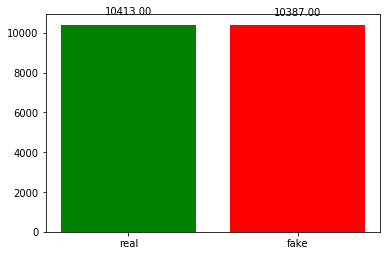

In [7]:
#Compare fake and real training dataset size to check if distribution is even/skewed

values = df_train['label'].value_counts()
plt.bar(x=["real", "fake"], height=values, color=["green", "red"])
for x,y in zip(["real", "fake"],values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # text
                 (x,y), # point to label
                 textcoords="offset points", # text position
                 xytext=(0,10), # distance from text to points
                 ha='center') # horizontal alignment
plt.show()

In [8]:
#Extract real data; rows with label = 0

df_reliable = df_train.loc[df_train['label'] == 0]
df_reliable.head(6)

,id,title,author,text,label
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0
10,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0


In [9]:
#Extract real data; rows with label = 1

df_fake = df_train.loc[df_train['label'] == 1]
df_fake.head(6)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
12,12,Russian Researchers Discover Secret Nazi Milit...,Amando Flavio,The mystery surrounding The Third Reich and Na...,1


In [10]:
#Add custom field article that combines text and title into same column article

df_train['article'] = df_train['title'] + ' ' + df_train['text']
df_train.drop(columns=['title', 'text'], inplace = True)
df_train.head(6)

,id,author,label,article
0,0,Darrell Lucus,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,Daniel J. Flynn,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Consortiumnews.com,1,Why the Truth Might Get You Fired Why the Trut...
3,3,Jessica Purkiss,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Howard Portnoy,1,Iranian woman jailed for fictional unpublished...
5,5,Daniel Nussbaum,0,Jackie Mason: Hollywood Would Love Trump if He...


In [11]:
#Clean up and preprocess data

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [12]:
def preprocessArticle(article):
    #Clean sentence to remove any punctuations, convert to lower case
    cleaned_sentence = re.sub(r'[^\w\s]', '', str(article).lower())
    #Tokenize sentence into words
    words = nltk.word_tokenize(cleaned_sentence)
    #Remove stop words and words with length less than equal to 3
    filtered_words = [word for word in words if not word in stop_words and len(word) > 3]
    #Lemmatize
    output_sentence = ''
    for word in filtered_words:
        output_sentence = output_sentence  + ' ' + str(lemmatizer.lemmatize(word))
    
    return output_sentence

In [13]:
for index, row in df_train.iterrows():
    cleaned_sentence = preprocessArticle(str(row['article']))
    df_train.loc[index, 'cleaned_article'] = cleaned_sentence

df_train.head(6)

,id,author,label,article,cleaned_article
0,0,Darrell Lucus,1,House Dem Aide: We Didn’t Even See Comey’s Let...,house aide didnt even comeys letter jason cha...
1,1,Daniel J. Flynn,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",flynn hillary clinton woman campus breitbart ...
2,2,Consortiumnews.com,1,Why the Truth Might Get You Fired Why the Trut...,truth might fired truth might fired october 2...
3,3,Jessica Purkiss,1,15 Civilians Killed In Single US Airstrike Hav...,civilian killed single airstrike identified v...
4,4,Howard Portnoy,1,Iranian woman jailed for fictional unpublished...,iranian woman jailed fictional unpublished st...
5,5,Daniel Nussbaum,0,Jackie Mason: Hollywood Would Love Trump if He...,jackie mason hollywood would love trump bombe...


In [14]:
#Sentiment analysis to see polarity difference if any between fake and real articles

df_reliable = df_train.loc[df_train['label'] == 0]
df_fake = df_train.loc[df_train['label'] == 1]

cleaned_reliable_articles = list(df_reliable['cleaned_article'])
cleaned_fake_articles = list(df_fake['cleaned_article'])

sentimentAnalyzer = SentimentIntensityAnalyzer()

#Sentiment analysis for reliable articles
sentimentscores = []
for i in cleaned_reliable_articles:
    score = sentimentAnalyzer.polarity_scores(i)
    score['article'] = i
    sentimentscores.append(score)
    
sentimentdf_reliable = pd.DataFrame(sentimentscores)

#Sentiment analysis for fake articles
sentimentscores = []
for i in cleaned_fake_articles:
    score = sentimentAnalyzer.polarity_scores(i)
    score['article'] = i
    sentimentscores.append(score)
    
sentimentdf_fake = pd.DataFrame(sentimentscores)

In [15]:
sentimentdf_reliable.head(6)

,neg,neu,pos,compound,article
0,0.142,0.686,0.172,0.8979,flynn hillary clinton woman campus breitbart ...
1,0.137,0.658,0.205,0.9094,jackie mason hollywood would love trump bombe...
2,0.039,0.748,0.213,0.9975,benoît hamon win french socialist party presi...
3,0.044,0.679,0.277,0.9995,excerpt draft script donald trump qampa black...
4,0.079,0.768,0.153,0.9968,backchannel plan ukraine russia courtesy trum...
5,0.078,0.846,0.076,-0.5318,obamas organizing action partner soroslinked ...


In [16]:
sentimentdf_fake.head(6)

,neg,neu,pos,compound,article
0,0.084,0.827,0.089,-0.3213,house aide didnt even comeys letter jason cha...
1,0.114,0.657,0.229,0.9979,truth might fired truth might fired october 2...
2,0.370,0.571,0.058,-0.9988,civilian killed single airstrike identified v...
3,0.246,0.716,0.038,-0.9753,iranian woman jailed fictional unpublished st...
4,0.014,0.781,0.205,0.9957,life life luxury elton john favorite shark pi...
5,0.102,0.818,0.080,-0.8316,russian researcher discover secret nazi milit...


In [17]:
sentimentdf_reliable.drop(columns=['article'], inplace = True)
average_sentiment_reliable = sentimentdf_reliable.mean()

sentimentdf_fake.drop(columns=['article'], inplace = True)
average_sentiment_fake = sentimentdf_fake.mean()


Sentiment_analysis..



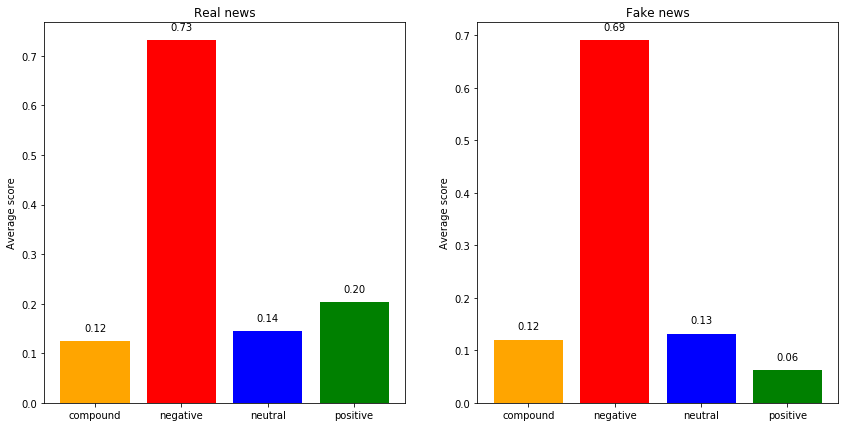

In [18]:
print("\nSentiment_analysis..\n")
names = ['compound', 'negative', 'neutral','positive']
colors=["orange", "red", "blue" , "green"]

plt.figure(figsize=(22, 7))
plt.subplot(131)
plt.bar(names,average_sentiment_reliable, color=colors)
plt.title("Real news")
plt.ylabel("Average score")
# zip joins x and y coordinates in pairs
for x,y in zip(names,average_sentiment_reliable):

    label = "{:.2f}".format(y)

    plt.annotate(label, # text
                 (x,y), # point to label
                 textcoords="offset points", # text position
                 xytext=(0,10), # distance from text to points
                 ha='center') # horizontal alignment
plt.subplot(132)
plt.bar(names,average_sentiment_fake, color=colors)
plt.title("Fake news")
plt.ylabel("Average score")
for x,y in zip(names,average_sentiment_fake):

    label = "{:.2f}".format(y)

    plt.annotate(label, # text
                 (x,y), # point to label
                 textcoords="offset points", # text position
                 xytext=(0,10), # distance from text to points
                 ha='center') # horizontal alignment

plt.show()

# Vectorization

In [19]:
df_x = df_train['cleaned_article']
df_y = df_train['label']
df_x.head(6)
df_y.head(6)

0    1
1    0
2    1
3    1
4    1
5    0
Name: label, dtype: int64

In [20]:
#Unigram and bigram term frequency matrix

count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2))
count_vectorizer.fit(df_x)
bigram_term_freq_matrix = count_vectorizer.transform(df_x)
print("\nbigram_term_freq_matrix:")
print(bigram_term_freq_matrix)


bigram_term_freq_matrix:
  (0, 28347)	1
  (0, 29066)	1
  (0, 34949)	2
  (0, 35902)	1
  (0, 38032)	1
  (0, 44480)	1
  (0, 44481)	1
  (0, 56445)	1
  (0, 56473)	1
  (0, 63958)	1
  (0, 64028)	1
  (0, 71733)	3
  (0, 71823)	1
  (0, 72851)	1
  (0, 73917)	1
  (0, 87221)	1
  (0, 87468)	1
  (0, 95347)	1
  (0, 96758)	1
  (0, 116792)	1
  (0, 117170)	1
  (0, 134246)	1
  (0, 135861)	1
  (0, 146535)	6
  (0, 146780)	2
  :	:
  (20799, 4211907)	1
  (20799, 4211908)	1
  (20799, 4221522)	1
  (20799, 4221523)	1
  (20799, 4221573)	1
  (20799, 4221574)	1
  (20799, 4221640)	1
  (20799, 4221641)	1
  (20799, 4221729)	1
  (20799, 4221730)	1
  (20799, 4222199)	1
  (20799, 4222200)	1
  (20799, 4222201)	1
  (20799, 4222202)	1
  (20799, 4222209)	1
  (20799, 4222210)	1
  (20799, 4222536)	1
  (20799, 4222537)	1
  (20799, 4226398)	4
  (20799, 4227909)	1
  (20799, 4229251)	1
  (20799, 4231063)	1
  (20799, 4233293)	1
  (20799, 4241123)	1
  (20799, 4241267)	1


In [21]:
#Unigram and bigram tf-idf matrix

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(bigram_term_freq_matrix)
bigram_tfidf_matrix = tfidf_transformer.transform(bigram_term_freq_matrix)
print("\nbigram_tfidf_matrix:")
print(bigram_tfidf_matrix)


bigram_tfidf_matrix:
  (0, 4235378)	0.03241195639621523
  (0, 4235376)	0.032105218768387074
  (0, 4234389)	0.02726253028841198
  (0, 4226398)	0.006356431508144326
  (0, 4203725)	0.039278291446639475
  (0, 4203297)	0.039278291446639475
  (0, 4203252)	0.028926605886906633
  (0, 4203031)	0.07544895675110866
  (0, 4202997)	0.03241195639621523
  (0, 4202694)	0.04662074613139837
  (0, 4198527)	0.039278291446639475
  (0, 4195182)	0.039278291446639475
  (0, 4194245)	0.03576690541704199
  (0, 4194182)	0.024672860548193117
  (0, 4185834)	0.039278291446639475
  (0, 4184095)	0.008663500135815693
  (0, 4162666)	0.039278291446639475
  (0, 4162665)	0.039278291446639475
  (0, 4134832)	0.03772447837555433
  (0, 4134300)	0.013783359013659992
  (0, 4130013)	0.039278291446639475
  (0, 4128818)	0.011176867224256417
  (0, 4127302)	0.030089138191623857
  (0, 4123501)	0.008134356497938377
  (0, 4121440)	0.0315568313562873
  :	:
  (20799, 149211)	0.019908571714262947
  (20799, 91550)	0.05670428718457794
  (20

# Split data into train/test groups

In [22]:
#Unigram and bigram tf-idf matrix split

train_x_bigram_tfidf, test_x_bigram_tfidf, train_y_bigram_tfidf, test_y_bigram_tfidf = train_test_split(bigram_tfidf_matrix, df_y)

# TRAINING

In [23]:
metrics = {}
attributes = ["accuracy", "precision(macro)", "precision(micro)", "recall(macro)", "recall(micro)", "f1_score(macro)", "f1_score(micro)"]

In [24]:
def assess_model_performance(classifier_model, test_x, test_y, name):
    true_y = test_y
    pred_y = classifier_model.predict(test_x)
    #Compute metrics
    accuracy = "%0.2f" % (classifier_model.score(test_x, true_y)*100) + "%"
    precision_macro = "%0.3f" % (precision_score(true_y, pred_y, average='macro'))
    precision_micro = "%0.3f" % (precision_score(true_y, pred_y, average='micro'))
    recall_macro = "%0.3f" %(recall_score(true_y, pred_y, average='macro'))
    recall_micro = "%0.3f" %(recall_score(true_y, pred_y, average='micro'))
    f1_macro = "%0.3f" %(f1_score(true_y, pred_y, average='macro'))
    f1_micro = "%0.3f" %(f1_score(true_y, pred_y, average='micro'))
    print("Accuracy: " + accuracy)
    print("Precision (macro): " + precision_macro)
    print("Precision (micro): " + precision_micro)
    print("Recall (macro): " + recall_macro)
    print("Recall (micro): " + recall_micro)
    print("F1Score (macro): " + f1_macro)
    print("F1Score (micro): " + f1_micro)
    
    #Add metrics to comparison data
    metrics[name] = pd.Series([accuracy, precision_macro, precision_micro, recall_macro, recall_micro, f1_macro, f1_micro], index=attributes)
    
    #Confusion matrix plot
    plot_confusion_matrix(classifier_model, test_x, true_y, display_labels=['RELIABLE', 'FAKE'], values_format="d")
    disp = plot_precision_recall_curve(classifier_model, test_x, true_y)
    disp.ax_.set_title('Precision-Recall curve')

In [25]:
#SVM (Linear SVC)

print("Linear SVC...")

Linear SVC...



With linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram and bigram tf-idf:
Accuracy: 96.02%
Precision (macro): 0.961
Precision (micro): 0.960
Recall (macro): 0.960
Recall (micro): 0.960
F1Score (macro): 0.960
F1Score (micro): 0.960


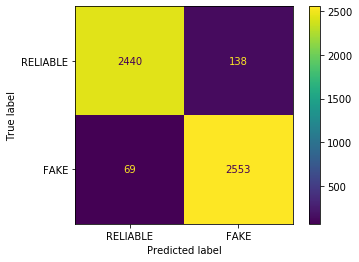

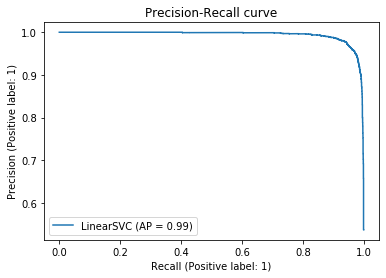

In [26]:
print("\nWith linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram and bigram tf-idf:")

linear_svc_c1_bigram_tfidf = LinearSVC(C=1.0, max_iter=1000)
linear_svc_c1_bigram_tfidf.fit(train_x_bigram_tfidf, train_y_bigram_tfidf)
assess_model_performance(linear_svc_c1_bigram_tfidf, test_x_bigram_tfidf, test_y_bigram_tfidf, "Linear SVC (TFIDF/Uni-bigram)")

In [27]:
#Pick final model (svc unigram tfidf classifier) based on performance assessment, create pipeline and export trained model

tfidf_unigram_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1))
pass_agg_unigram_tfidf_classifier = PassiveAggressiveClassifier()
svc_unigram_tfidf_classifier = LinearSVC(C=1.0, max_iter=1000)
pipeline = Pipeline([('vectorizer', tfidf_unigram_vectorizer), ('classifier', pass_agg_unigram_tfidf_classifier)])
X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, random_state=0)
pipeline.fit(X_train, Y_train)
print(pipeline.score(X_test, Y_test))

0.9588461538461538


In [46]:
joblib.dump(pipeline, 'final_trained_model.sav')

['final_trained_model.sav']

In [29]:
#Load saved model
classifier = joblib.load('final_trained_model.sav')

In [30]:
prediction_mapper = {0:"RELIABLE", 1:"FAKE"}

In [31]:
#Sample test

title = "Keiser Report: Meme Wars (E995)"
text = "42 mins ago 1 Views 0 Comments 0 Likes 'For the first time in history, we‚Äôre filming a panoramic video from the station. It means you‚Äôll see everything we see here, with your own eyes. That‚Äôs to say, you‚Äôll be able to feel like real cosmonauts' - Borisenko to RT. Video presented by RT in collaboration with the Russian space agency Roscosmos and the rocket and space corporation Energia More on our project website: space360.rt.com   Subscribe   Like     Leave a Reply Login with your Social ID Your email address will not be published. Name";
article = preprocessArticle(str(title) + str(text))
print("Input: " + article)
predict = classifier.predict(pd.Series(article))
for prediction in predict:
    print("Prediction: " + prediction_mapper.get(prediction))

Input:  keiser report meme war e99542 min view comment like first time history weäôre filming panoramic video station mean youäôll everything eye thatäôs youäôll able feel like real cosmonaut borisenko video presented collaboration russian space agency roscosmos rocket space corporation energia project website space360rtcom subscribe like leave reply login social email address published name
Prediction: FAKE


In [32]:
article = preprocessArticle(str("Taiwan's key semiconductor industry has years of growth ahead of it with no worries about oversupply despite a massive capital investment programme and only a few competitors in the next decade or so, a senior government minister said on Friday."))
print("Input: " + article)
predict = classifier.predict(pd.Series(article))
for prediction in predict:
    print("Prediction: " + prediction_mapper.get(prediction))                           

Input:  taiwan semiconductor industry year growth ahead worry oversupply despite massive capital investment programme competitor next decade senior government minister said friday
Prediction: RELIABLE


In [44]:
article = str("Taiwan's key semiconductor industry has years of growth ahead of it with no worries about oversupply despite a massive capital investment programme and only a few competitors in the next decade or so, a senior government minister said on Friday.")
print("Input: " + article)
predict = classifier.predict(pd.Series(article))
for prediction in predict:
    print("Prediction: " + prediction_mapper.get(prediction))

Input: Taiwan's key semiconductor industry has years of growth ahead of it with no worries about oversupply despite a massive capital investment programme and only a few competitors in the next decade or so, a senior government minister said on Friday.
Prediction: FAKE


In [35]:
#Read test data (for Kaggle submission)

zf1 = zipfile.ZipFile('test.csv.zip')
df_test = pd.read_csv(zf1.open('test.csv'))
df_test.head(6)

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...
5,20805,Trump is USA's antique hero. Clinton will be n...,NaN,Trump is USA's antique hero. Clinton will be n...


In [36]:
#Preprocess test data

for index, row in df_test.iterrows():
    cleaned_sentence = preprocessArticle(str(row['title']) + str(row['text']))
    df_test.loc[index, 'cleaned_article'] = cleaned_sentence

df_test.head(6)

,id,title,author,text,cleaned_article
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",specter trump loosens tongue purse string sil...
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,russian warship ready strike terrorist near a...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,nodapl native american leader stay winter fil...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",tebow attempt another comeback time baseball ...
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,keiser report meme war e99542 min view commen...
5,20805,Trump is USA's antique hero. Clinton will be n...,NaN,Trump is USA's antique hero. Clinton will be n...,trump usa antique hero clinton next president...


In [37]:
#Get predictions on articles in test file

predict = classifier.predict(df_test['cleaned_article'])
results = []
for prediction in predict:
    results.append(prediction_mapper.get(prediction))
print(results[:10])

['RELIABLE', 'FAKE', 'FAKE', 'RELIABLE', 'FAKE', 'FAKE', 'RELIABLE', 'FAKE', 'FAKE', 'FAKE']


In [38]:
test_id=df_test["id"]
print(test_id)

0       20800
1       20801
2       20802
3       20803
4       20804
        ...  
5195    25995
5196    25996
5197    25997
5198    25998
5199    25999
Name: id, Length: 5200, dtype: int64


In [39]:
#Create final submission dataframe

submit_df = pd.DataFrame({"id":test_id,
                         "label":predict})
submit_df.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [40]:
submit_df.to_csv("submit_ans.csv", index=False)

In [41]:
df_metrics = pd.DataFrame(metrics)
df_metrics.transpose()

,accuracy,precision(macro),precision(micro),recall(macro),recall(micro),f1_score(macro),f1_score(micro)
Linear SVC (TFIDF/Uni-bigram),96.02%,0.961,0.960,0.960,0.960,0.960,0.960


In [42]:
df_metrics.transpose().to_csv("performance_metrics.csv", index=True)

In [48]:
sc = preprocessArticle(article)
joblib.dump(sc, 'preprocess.sav')

['preprocess.sav']

In [49]:
sc = joblib.load('final_trained_model.sav')

In [4]:
pip install pickle-mixin

Processing c:\users\shreya\appdata\local\pip\cache\wheels\d0\70\0b\673e09a7ed429660d22352a1b117b4f616a8fc054bdd7eb157\pickle_mixin-1.0.2-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pickle

In [6]:
classifier1 = pickle.load(open("final_trained_model.sav"))

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 32: character maps to <undefined>

In [55]:
article = str("Taiwan's key semiconductor industry has years of growth ahead of it with no worries about oversupply despite a massive capital investment programme and only a few competitors in the next decade or so, a senior government minister said on Friday.")
print("Input: " + article)
print(preprocessArticle(article))
predict = classifier.predict(pd.Series(sc.transform(article)))
for prediction in predict:
    print("Prediction: " + prediction_mapper.get(prediction))

Input: Taiwan's key semiconductor industry has years of growth ahead of it with no worries about oversupply despite a massive capital investment programme and only a few competitors in the next decade or so, a senior government minister said on Friday.
 taiwan semiconductor industry year growth ahead worry oversupply despite massive capital investment programme competitor next decade senior government minister said friday


AttributeError: 'PassiveAggressiveClassifier' object has no attribute 'transform'